# The Distribution of Metals

In [72]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.paths import Paths
from auriga.parser import parse
from auriga.physics import Physics
from auriga.settings import Settings

In [73]:
figure_setup()

In [74]:
def read_data(simulation: str) -> tuple:
    """
    Read the properties of interest for this analysis.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)
    s.add_metals()

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.region_tag[is_real_star & is_main_obj],
        s.mass[is_real_star & is_main_obj],
        s.metals[is_real_star & is_main_obj])

In [75]:
def prepare_data(region_tag: np.ndarray,
                 mass: np.ndarray,
                 metals: np.ndarray,
                 ) -> tuple:
    """
    This method takes the region tag, the mass of each star and the metal
    mass fractions and prepares the data to plot.

    Parameters
    ----------
    region_tag : np.ndarray
        The region tag.
    mass : np.ndarray
        The mass of the particles.
    metals : np.ndarray
        The metal mass fraction for each particle and each chemical element.

    Returns
    -------
    tuple
        The prepared data.
    """

    settings = Settings()
    physics = Physics()

    # Metal fractions
    metal_fractions = np.zeros((len(physics.metals), len(settings.components)))
    for i, metal in enumerate(physics.metals):
        for region in np.unique(region_tag):
            is_region = (region_tag == region)
            total_metal_mass = (metals[:, i] * mass).sum()
            region_metal_mass = (metals[is_region, i] * mass[is_region]).sum()
            metal_fractions[i, region] = region_metal_mass / total_metal_mass
    metal_fractions *= 100

    # Numerical labels
    numerical_labels = np.empty(metal_fractions.shape, dtype=object)
    for i in range(numerical_labels.shape[0]):
        for j in range(numerical_labels.shape[1]):
            if metal_fractions[i, j] >= 11.0:
                numerical_labels[i, j] = r"$\textbf{" \
                    + str(np.round(metal_fractions[i, j], 1)) \
                    + r"\%" "}$"
            else:
                numerical_labels[i, j] = ""

    # # Categorical labels
    # labels = np.array(
    #     ["Galaxy"] + [
    #     item.replace(" ", "\n") for item in \
    #         settings.component_labels.values()])

    # # Colors
    # colors = np.array(["tab:gray"] + list(settings.component_colors.values()))

    # order_idx = np.argsort(bar_widths)
    return metal_fractions, numerical_labels

In [80]:
def plot_metal_dist_for_galaxy(simulation: str):
    data = read_data(simulation=simulation)
    metal_fractions, numerical_labels = prepare_data(
        region_tag=data[0],
        mass=data[1],
        metals=data[2])
    settings = Settings()
    physics = Physics()

    fig = plt.figure(figsize=(4.0, 4.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    ax.label_outer()
    ax.tick_params(which='both', direction="in",
                   bottom=False, top=False, left=False, right=False)
    ax.set_xlim(0, 100)
    ax.set_ylim(-1, 9)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    bar_width = 0.75
    bottom = np.zeros(len(physics.metals))
    for i, component in enumerate(settings.components):
        hbars = ax.barh(y=np.arange(len(physics.metals)),
                        width=metal_fractions[:, i],
                        height=bar_width,
                        color=list(settings.component_colors.values())[i],
                        linewidth=0,
                        left=bottom,
                        label=settings.component_labels[component])
        ax.bar_label(hbars,
                    labels=numerical_labels[:, i],
                    label_type="center",
                    fontsize=6.0)
        bottom += metal_fractions[:, i]

    ax.set_yticks(np.arange(len(physics.metals)), labels=physics.metals)
    ax.set_xlabel('Stellar Metal Mass Distribution [\%]')

    ax.legend(bbox_to_anchor=(0.5, 0.95),
            ncol=4,
            framealpha=0,
            loc='lower center',
            fontsize=6.0)

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1] + 0.5,
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

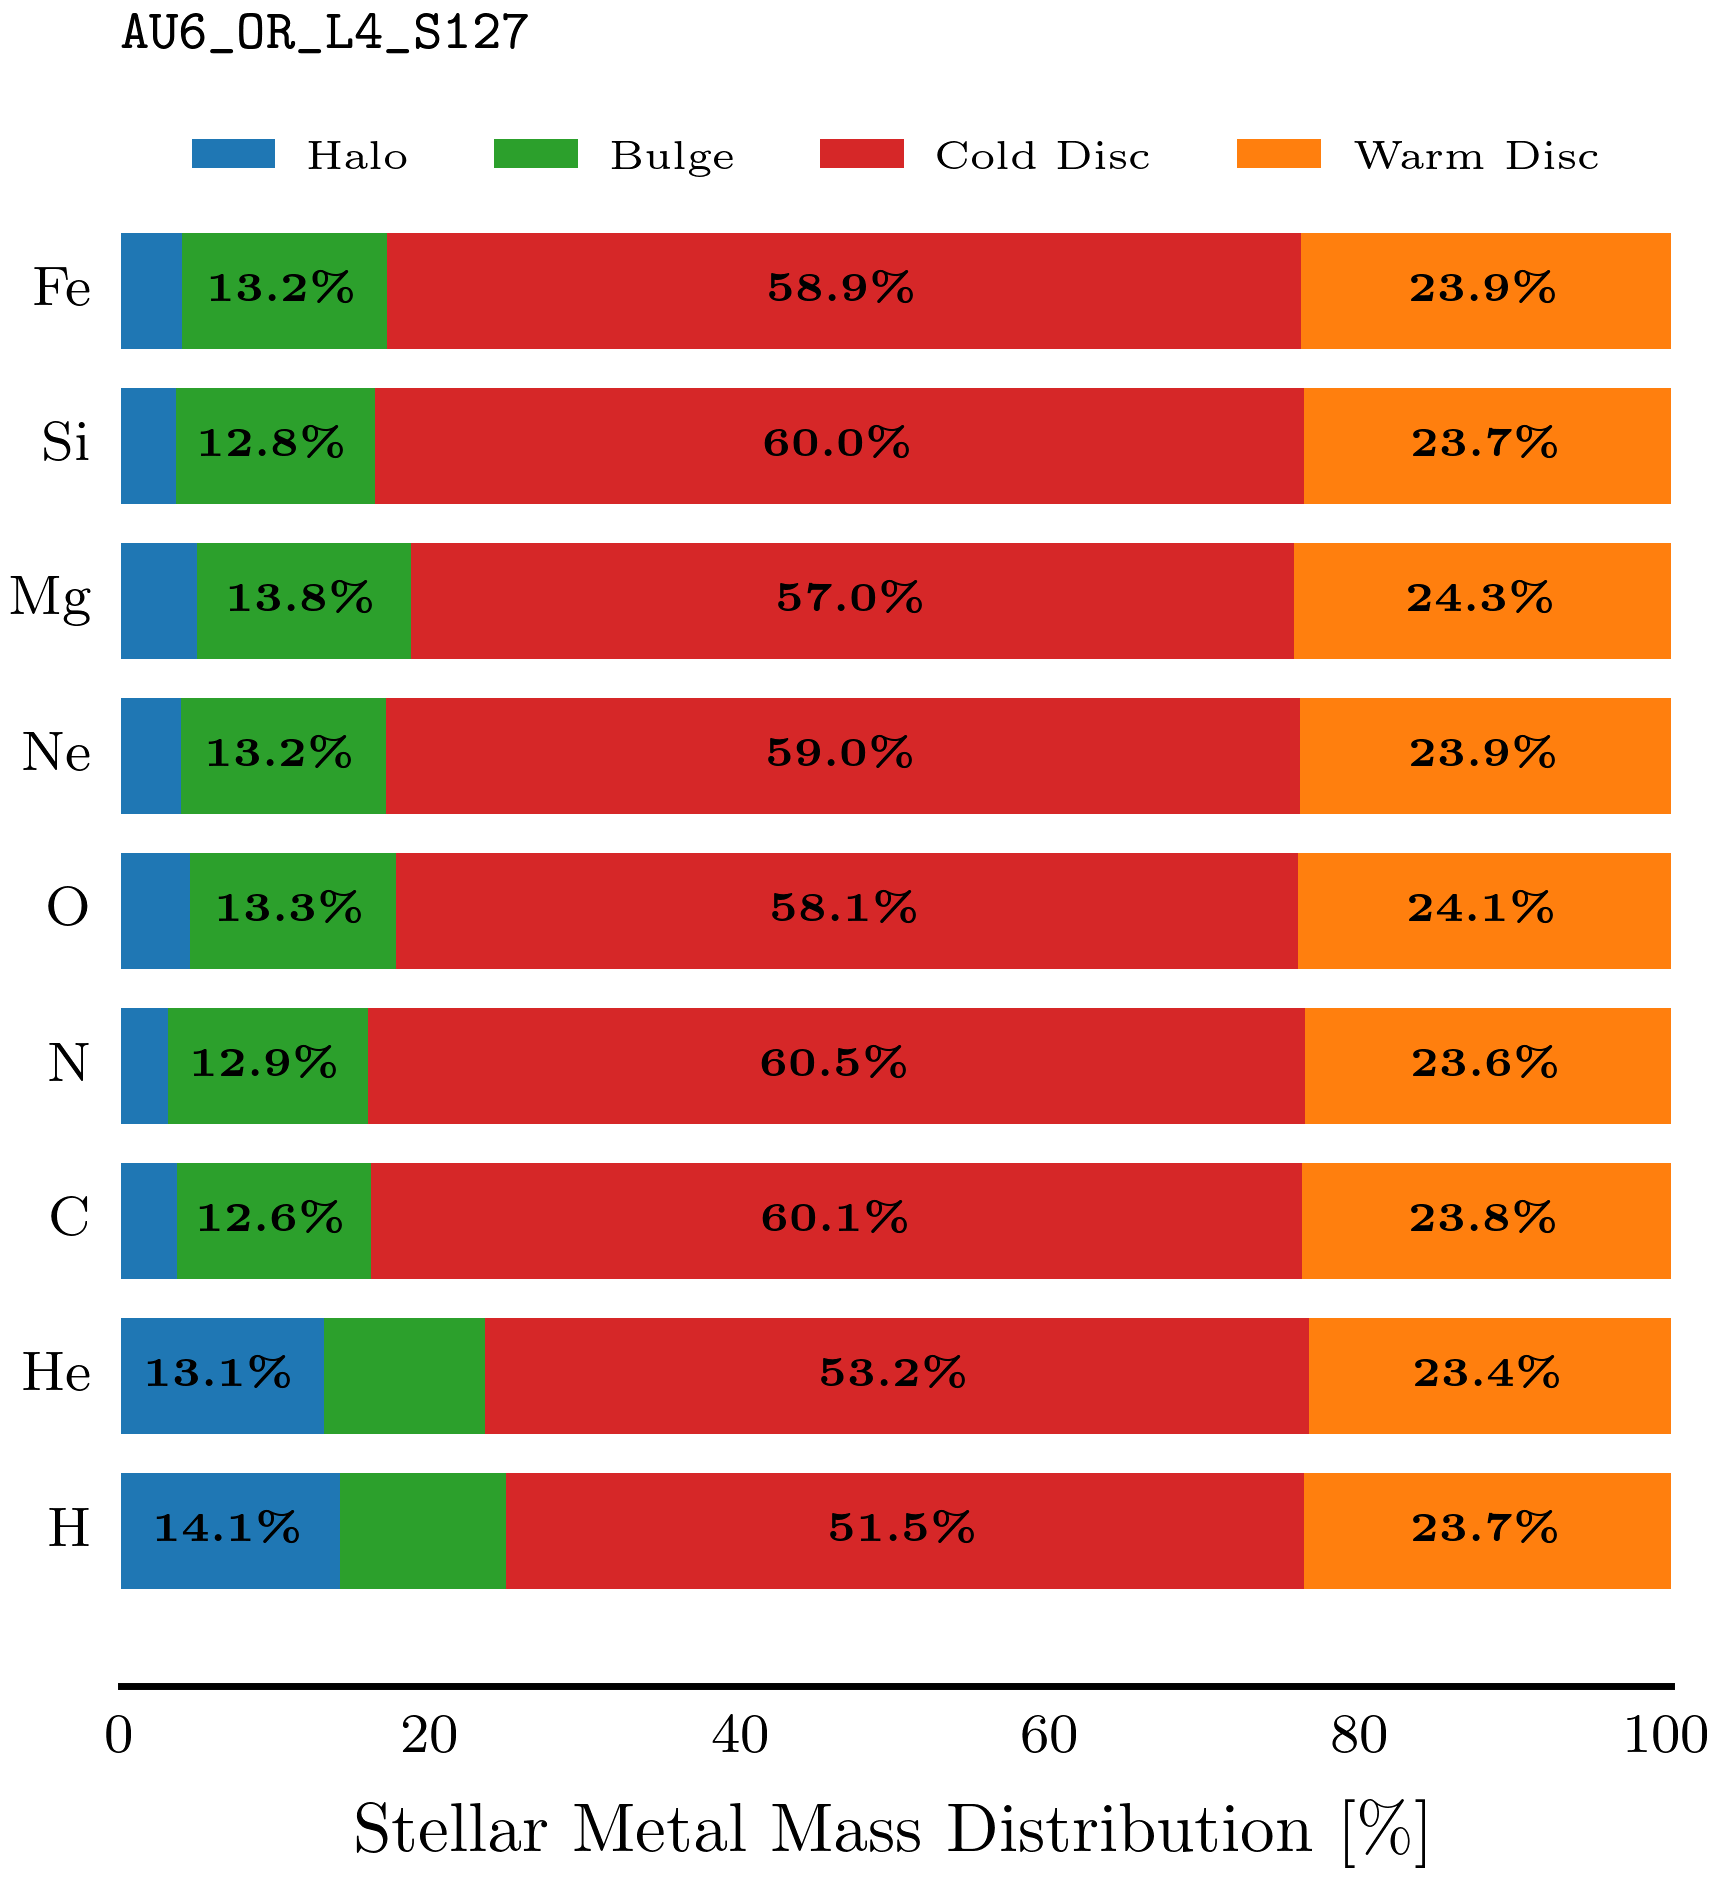

In [81]:
plot_metal_dist_for_galaxy(simulation="au6_or_l4_s127")